# PyRAF: Fully loaded

This notebook illustrates how to find all of the tasks available in the current IRAF/PyRAF distribution.  

In [1]:
from __future__ import print_function
from pyraf import iraf
from stsci.tools.irafglobals import IrafTask, IrafPkg, IrafError
from types import FunctionType
from astropy.table import Table
import xlsxwriter

In [2]:
def load_all_packages():
    """Recursively load all IRAF packages into the current namespace
    
    Parameters
    ----------
    None
    
    Returns
    -------
    errored_packages : dict
        package name and exception for any packages that could not be loaded
    
    """
    
    errored_packages = {}
    
    previous_size = 0
    
    #-- Iterate until no new packages have been loaded
    while len(iraf.mmdict) > previous_size:
        previous_size = len(iraf.mmdict)
       
        for name in list(iraf.mmdict.keys()):
            obj = iraf.mmdict[name]
            
            if isinstance(obj, IrafPkg):
                try:
                    print("Loading {}".format(name))
                    obj()
                except (AttributeError, ImportError, IrafError, EOFError) as e:
                    errored_packages[get_full_path(name)] = e
                    print("ERROR WITH: {}".format(name))
                    print("   BECAUSE: {}".format(e.message))
                    
    return errored_packages

In [3]:
def get_full_path(taskname):
    """Assemble full path name for a given IRAF task
    
    Find the task's parent, then each parent's parent until the top-level 
    ("clpackage") is reached.  All parents and the task will be concatenated and
    separated by ".". 
    
    Parameters
    ----------
    taskname : str
        Name of any IRAF task loaded into the namespace
        
    Returns
    -------
    outname : str
        Full path to the input task through the namespace
        
    Examples
    --------
        >>> get_full_path('mscombine')
        'clpackage.stsdas.toolbox.imgtools.mstools.mscombine'
    """
    
    outname = getattr(iraf, taskname).getPkgname() + '.' + taskname
    
    while outname.split('.')[0] != 'clpackage':
        outname = getattr(iraf, outname.split('.')[0]).getPkgname() + '.' + outname
        
    return outname

In [18]:
def find_all_tasks():
    """Find all tasks loaded into the current namespace
    
    Ignoring built-in functions, assemble the sorted list
    of all currently available IRAF tasks.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    all_tasks : list
        Full path of all currently available tasks.
    """
    
    all_tasks = []
    for name in list(iraf.mmdict.keys()):
        obj = iraf.mmdict[name]
            
        #-- cannot check only if instance of IrafTask, as an IrafTask
        #-- also are subclasses of IrafPkg.
        if not isinstance(obj, IrafPkg) and isinstance(obj, IrafTask):
            #print get_full_path(name)
            complete_task = get_full_path(name)
            
            #-- weed out things we don't care about
            
            #-- cmd line functions like cp, wc, vi, etc
            if complete_task.startswith('clpackage.user.'):
                continue
                
            #-- Iraf or Pyraf internal utilites
            if complete_task.startswith('clpackage.system'):
                continue
                
            #-- logout function
            if complete_task == 'clpackage._logout':
                continue
            
            #-- cl function
            if complete_task == 'clpackage.cl':
                continue
                
            #-- stuff to build packages it seems
            if complete_task.startswith('clpackage.softools.'):
                continue
            
            all_tasks.append(get_full_path(name))
            
    return sorted(all_tasks)

## Loading every package and sub-package we can find

A single call to `load_all_packages()` will continuously load every package and sub-package it can find untill no more sub-packages have been added to the namespace.  It will also return any failed packages, so that we can diagnose any failures.

In [6]:
failed = load_all_packages()

Loading nfextern
nfextern/:
 ace/           msctools/       newfirm/        odi/
Loading tv
Loading imfit
Loading song
ERROR WITH: song
   BECAUSE: Undefined IRAF task `rvx'
Loading obsolete
obsolete/:
 imtitle        ofixpix         oimstatistics   owfits
 mkhistogram    oimcombine      orfits          radplt
Loading guiapps
guiapps/:
 demo           spt/            xapphot/        xhelp           xrv/
Loading cfh12k


/Users/ely/anaconda/envs/iraf/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6


This is the initial release of the IRAF FITSUTIL package
to include support for FITS tile compression via 'fpack'.
Please send comments and questions to seaman@noao.edu.

cfh12k/:
 hdrcfh12k      setcfh12k
Loading nttools
Loading iis
iis/:
 blink          erase           monochrome      window
 cv             frame           pseudocolor     zoom
 cvl            lumatch         rgb
Loading plot
Loading rvsao

#-----------------------------------------------------------+
#           RVSAO Radial Velocity Analysis Package          |
#           Smithsonian Astrophysical Observatory           |
#                   Telescope Data Center                   |
#              Version 2.7.8 November 20, 2009              |
#-----------------------------------------------------------+

rvsao/:
 bcvcorr        eqwidth         pxcsao          setvel          wlrange
 contpars@      linespec        qplot           skyplot         xcplot
 contsum@       listspec        qplotc          sumspec         

In [7]:
print("Found {} failed packages.".format(len(failed)))
print("-"*20)
for item in failed:
    print(item, ' ->', failed[item])

Found 9 failed packages.
--------------------
clpackage.song  -> Undefined IRAF task `rvx'
clpackage.stsdas.analysis.dither  -> No module named pydrizzle
clpackage.mscdb  -> Cannot find executable for task mscdb
Tried /Users/ely/anaconda/envs/iraf/iraf/bin.macosx/mscdb.cl, /Users/ely/anaconda/envs/iraf/variants/common//iraf/mscdb/mscdb.cl
clpackage.noao.twodspec.apextract.apdemos  -> EOF on parameter prompt
clpackage.noao.obsutil.kpno  -> Undefined variable `spectimedb' in string `spectimedb$'
clpackage.stsdas.sobsolete  -> Cannot find executable for task sobsolete
Tried /Users/ely/anaconda/envs/iraf/variants/common//iraf/stsci_iraf//stsdas/bin/sobsolete.cl, /Users/ely/anaconda/envs/iraf/variants/common//iraf/stsci_iraf//stsdas/pkg/sobsolete/sobsolete.cl
clpackage.kepler  -> No module named pyfits
clpackage.xray.xlocal  -> Cannot find executable for task xlocal
Tried /Users/ely/anaconda/envs/iraf/variants/common//iraf/xray/bin.macosx/xlocal.cl, /Users/ely/anaconda/envs/iraf/variants/co

## After all packages have been loaded, now we need to identify every task

In [20]:
every_loaded_task = find_all_tasks()
print("Found {} loaded tasks.".format(len(every_loaded_task)))

Found 2070 loaded tasks.


In [21]:
for item in every_loaded_task:
    print(item)

clpackage.adccdrom.catalog
clpackage.adccdrom.spectra
clpackage.adccdrom.tbldb
clpackage.cfh12k.hdrcfh12k
clpackage.cfh12k.setcfh12k
clpackage.cirred.atmo_cor
clpackage.cirred.calc_off
clpackage.cirred.clearim
clpackage.cirred.do_ccmap
clpackage.cirred.do_osiris
clpackage.cirred.do_wcs
clpackage.cirred.extra
clpackage.cirred.fixbad
clpackage.cirred.fixfits
clpackage.cirred.irdiff
clpackage.cirred.maskbad
clpackage.cirred.med
clpackage.cirred.osiris
clpackage.cirred.shift_comb
clpackage.cirred.sky_sub
clpackage.cirred.spec_comb
clpackage.ctio.apropos
clpackage.ctio.bin2iraf
clpackage.ctio.bitstat
clpackage.ctio.chpixfile
clpackage.ctio.colselect
clpackage.ctio.compairmass
clpackage.ctio.compression._compress
clpackage.ctio.compression._uncompress
clpackage.ctio.compression.fitsread
clpackage.ctio.compression.fitswrite
clpackage.ctio.compression.imcompress
clpackage.ctio.compression.improc
clpackage.ctio.compression.imuncompress
clpackage.ctio.coords
clpackage.ctio.cureval
clpackage.ctio

### Just for a prettier view

In [22]:
max_size = 0
for item in every_loaded_task:
    size = len(item.split('.')[1:])
    
    if size > max_size:
        max_size = size
    

all_rows = []
for item in every_loaded_task:
    split_path = item.split('.')[1:]
    new_row = [item for item in split_path[:-1]] + ['' for i in range(max_size - len(split_path[:-1]) -1)] + [split_path[-1]]
    all_rows.append(tuple(new_row))
    
    
names = tuple(['base'] + ['sub{}'.format(i) for i in range(max_size - 2)] + ['task'])
dtype = ['S10'] * max_size

t = Table(rows=all_rows, names=names, dtype=dtype)

In [23]:
t.show_in_notebook()

base,sub0,sub1,sub2,task
adccdrom,,,,catalog
adccdrom,,,,spectra
adccdrom,,,,tbldb
cfh12k,,,,hdrcfh12k
cfh12k,,,,setcfh12k
cirred,,,,atmo_cor
cirred,,,,calc_off
cirred,,,,clearim
cirred,,,,do_ccmap
cirred,,,,do_osiris


### write to Excel

In [24]:
workbook = xlsxwriter.Workbook('iraf_modules.xlsx')
worksheet = workbook.add_worksheet('Models')
for rownum in range(len(all_rows)):
    for colnum in range(len(all_rows[rownum])):
        worksheet.write(rownum, colnum, all_rows[rownum][colnum])
        

workbook.close()

# Finding IRAF on github

In [46]:
import github3
import re
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
username = ''
password = ''
gh = github3.login(username, password)

In [41]:
%%time
all_matches = []
for item in gh.search_code("iraf in:file language:python", text_match=True):
    for row in item.text_matches:
        #print(repr(row['fragment']))
        hits = re.findall("iraf\.(?P<name>[A-Za-z\t .]+)\(", row['fragment'])
        for call in hits:
            all_matches.append(call.split('.')[-1])


CPU times: user 459 ms, sys: 11.7 ms, total: 471 ms
Wall time: 9.69 s


In [47]:
freqs = Counter(all_matches).most_common()

In [55]:
for name, count in freqs:
    print(count, name)

71 noao
66 imred
59 ccdred
42 images
40 unlearn
31 digiphot
30 imcopy
24 setParam
23 display
20 osfn
19 hedit
18 daophot
17 imarith
16 onedspec
15 stsdas
13 imgets
13 immatch
13 imutil
12 imexamine
9 obsutil
9 twodspec
8 rv
8 kpnoslit
8 tv
7 plot
7 IrafTaskFactory
7 set
7 imstat
6 ccdproc
6 astutil
6 imcoords
6 apphot
5 splot
5 pradprof
5 ptools
4 load
4 specred
4 analysis
4 toolbox
4 task
4 flatcombine
4 setVerbose
4 imfilter
4 proto
3 reset
3 longslit
3 imcombine
3 flprcache
3 astcat
2 imdel
2 ttools
2 prow
2 apextract
2 imhead
2 files
2 rvcorrect
2 flpr
2 gemini
2 deftask
2 imgtool
2 martin
2 dither
2 stis
2 imaccess
2 cd
2 daofind
2 calcphot
2 zerocombine
1 chdir
1 wspectext
1 saltred
1 tvmark
1 restore
1 imexam
1 findpars
1 hselect
1 geomap
1 astut
1 pysalt
1 imcalc
1 ccdhedit
1 psort
1 apt
1 kepler
1 tables
1 imcomb
1 scombine
1 sarith
1 imfit
1 tprint
1 ls
1 imalign
1 fitting
1 directory
1 magnify
1 geoxy
1 modatfile
1 setjd
1 blkavg
1 disp
1 gemtools
1 saltspec
1 pdump
1 ech
1 

(array([ 54.,  19.,   0.,   5.,   0.,   9.,   3.,   0.,   4.,   0.,   4.,
          0.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   3.,   0.,
          0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]), array([  1.        ,   1.57377049,   2.14754098,   2.72131148,
          3.29508197,   3.86885246,   4.44262295,   5.01639344,
          5.59016393,   6.16393443,   6.737

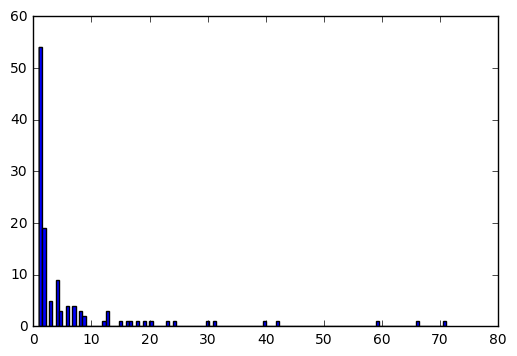

In [50]:
plt.hist([item[1] for item in freqs], bins=len(freqs))